In [1]:
import sys
sys.path.append("../../src")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import ColumnwiseRBF, RBF, FourthOrderGaussianKernel
from causal_models.proxy_causal_learning import KernelAlternativeProxyATT, KernelNegativeControlATT
from causal_models.causal_learning import KernelATT
from generate_experiment_data import generate_synthetic_data

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
data_size = 1000
seed = np.random.randint(1000000)
np.random.seed(seed)

U, W, Z, A, Y, do_A, EY_do_A = generate_synthetic_data(size = data_size, seed = seed)

W, Z, A, Y, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

train_data_perc = 1.0
test_data_perc = 1 - train_data_perc

indices = np.random.permutation(A.shape[0])
train_data_size = int(A.shape[0] * train_data_perc)
training_idx, test_idx = indices[:train_data_size], indices[train_data_size:]

A_train, Y_train, W_train, Z_train = A[training_idx], Y[training_idx], W[training_idx], Z[training_idx]

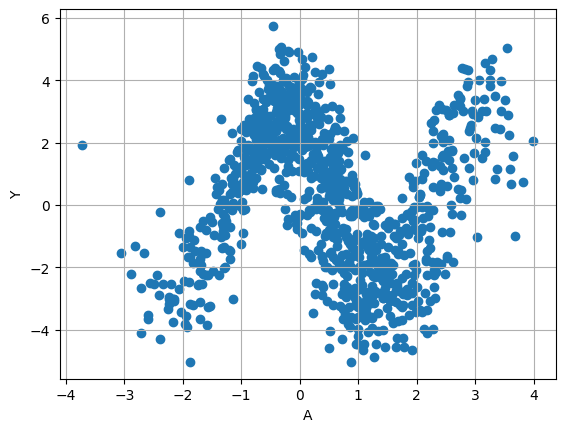

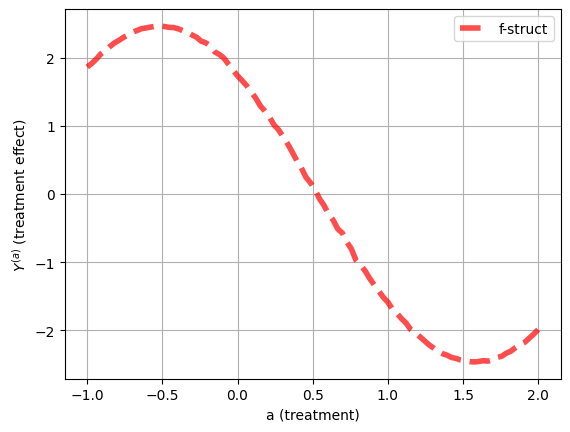

In [4]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()

# Hyperparameters for the Model

In [5]:
RBF_Kernel_Z = RBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_W = ColumnwiseRBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_A = RBF(use_length_scale_heuristic = True, use_jit_call = True)

lambda_ = 1e-2
eta = 2*1e-3
lambda2_ = 1e-3
optimize_lambda_parameters = True
optimize_eta_parameter = True
optimize_zeta_parameter = True
lambda_optimization_range = (1e-7, 1.0)
zeta_optimization_range = (1e-7, 1.0)
eta_optimization_range = (1e-7, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150


model = KernelAlternativeProxyATT(
                                     kernel_A = RBF_Kernel_A,
                                     kernel_W = RBF_Kernel_W, 
                                     kernel_Z = RBF_Kernel_Z,
                                     lambda_ = lambda_,
                                     eta = eta,
                                     lambda2_ = lambda2_,
                                     optimize_lambda_parameters = optimize_lambda_parameters,
                                     optimize_eta_parameter = optimize_eta_parameter,
                                     optimize_zeta_parameter = optimize_zeta_parameter,
                                     lambda_optimization_range = lambda_optimization_range,
                                     zeta_optimization_range = zeta_optimization_range,
                                     eta_optimization_range = eta_optimization_range,
                                     stage1_perc = stage1_perc,
                                     regularization_grid_points = regularization_grid_points, 
                                     label_variance_in_eta_opt = 1.,
                                  )

# Fit the Model and Make Predictions

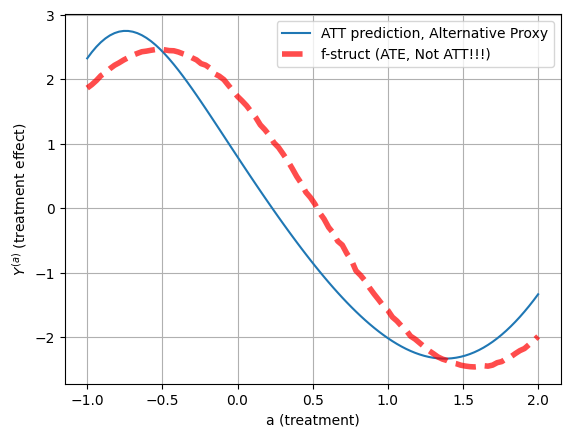

In [6]:
aprime = jnp.array([1.75])
model.fit((A_train, W_train, Z_train), Y_train, aprime)

f_struct_pred = model.predict(do_A)

plt.plot(do_A, f_struct_pred, label = "ATT prediction, Alternative Proxy")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct (ATE, Not ATT!!!)")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()

0.004988690685844123


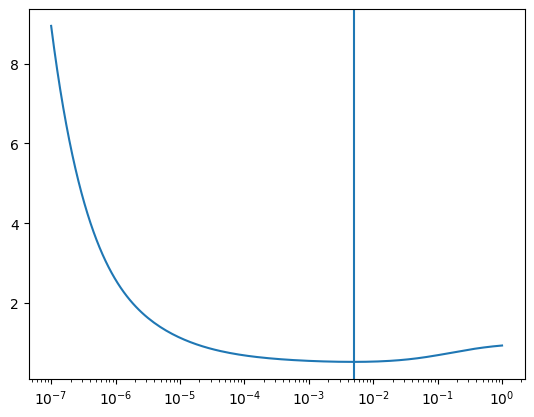

In [7]:
plt.semilogx(model.lambda_list, model.lambda_objective_list)
plt.axvline(model.lambda_)
print(model.lambda_) 

0.0029046061215980442


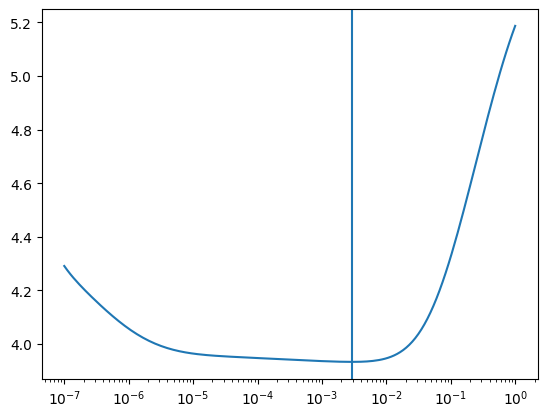

In [8]:
plt.semilogx(model.lambda_list, model.lambda2_objective_list)
plt.axvline(model.lambda2_)
print(model.lambda2_) 

0.0006388062072657211


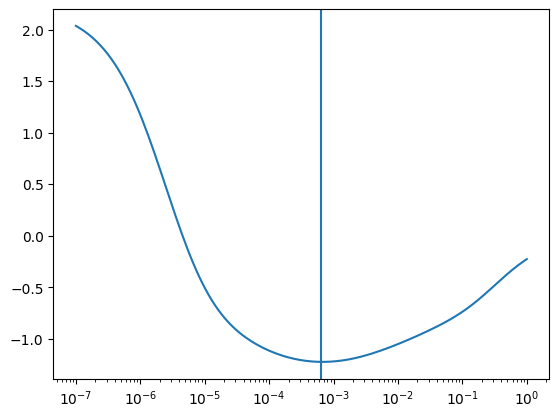

In [9]:
plt.semilogx(model.eta_list, model.eta_objective_list)
plt.axvline(model.eta)
print(model.eta) 

0.013207036227366296


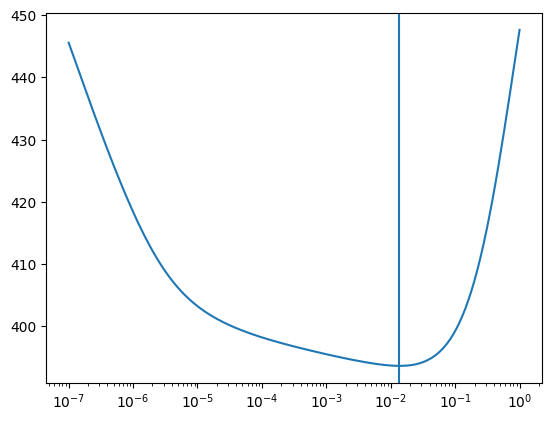

In [10]:
plt.semilogx(model.zeta_list, model.zeta_objective_list)
plt.axvline(model.zeta)
print(model.zeta) 

<StemContainer object of 3 artists>

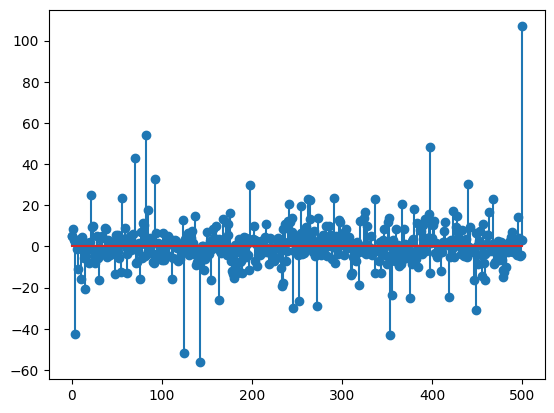

In [11]:
plt.stem(model.alpha)

# Comparison with Kernel Negative Control and Kernel ATT Methods

In [12]:
RBF_Kernel_Z = RBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_W = ColumnwiseRBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_A = RBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_X = RBF(use_length_scale_heuristic = True, use_jit_call = True)

lambda_ = 1e-3
zeta = 1*1e-3
lambda2 = 1e-3
optimize_regularization_parameters = True
lambda_optimization_range = (1e-9, 1.0)
zeta_optimization_range = (1e-9, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150

model_KNC = KernelNegativeControlATT(
                                 kernel_A = RBF_Kernel_A,
                                 kernel_W = RBF_Kernel_W,
                                 kernel_Z = RBF_Kernel_Z,
                                 lambda_ = lambda_,
                                 zeta = zeta, 
                                 lambda2 = lambda2,
                                 optimize_regularization_parameters = optimize_regularization_parameters,
                                 lambda_optimization_range = lambda_optimization_range,
                                 zeta_optimization_range = zeta_optimization_range,
                                )


U_train = U[training_idx]
RBF_Kernel_A_ = RBF(use_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_X_ = RBF(use_length_scale_heuristic = True, use_jit_call = True)

model_KernelATT = KernelATT(
    kernel_A = RBF_Kernel_A_,
    kernel_X = RBF_Kernel_X_,
)

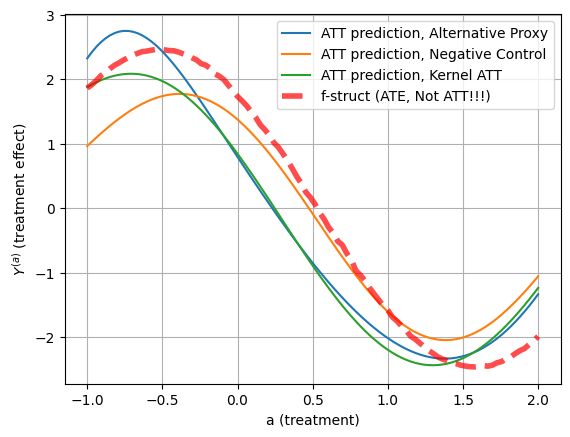

In [13]:
model_KNC.fit((A_train, W_train, Z_train), Y_train)
model_KernelATT.fit((A_train, U_train), Y_train)

f_struct_pred_knc = model_KNC.predict(do_A, aprime)
f_struct_pred_katt = model_KernelATT.predict(do_A, aprime)

plt.plot(do_A, f_struct_pred, label = "ATT prediction, Alternative Proxy")
plt.plot(do_A, f_struct_pred_knc, label = "ATT prediction, Negative Control")
plt.plot(do_A, f_struct_pred_katt, label = "ATT prediction, Kernel ATT")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct (ATE, Not ATT!!!)")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()